# Importing

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
# importing climate and pleasant weather data sets
path = r'C:\Users\Administrator\Desktop\Projects (Carrer foundry)\Data sets'
df_clean = pd.read_csv(os.path.join(path, 'Climate_Cleaned.csv'))
pleasant_clean = pd.read_csv(os.path.join(path, 'Pleasant_Day_Cleaned.csv'))
climate = pd.read_csv(os.path.join(path, 'Dataset-weather-prediction-dataset-processed.csv'))
climate_answers = pd.read_csv(os.path.join(path, 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))

# Data prep

In [3]:
df_clean.drop('Unnamed: 0', axis = 1, inplace = True)
# adding back in the date information so we can refine our time period for the dec
df_clean.insert(0, 'DATE', climate['DATE'])
df_clean.insert(1, 'MONTH', climate['MONTH'])
df_clean.head()
df_10 = df_clean[df_clean['DATE'].astype(str).str.startswith('201')]
df_00 = df_clean[df_clean['DATE'].astype(str).str.startswith('200')]
answers_10 = climate_answers[climate_answers['DATE'].astype(str).str.startswith('201')]
answers_00 = climate_answers[climate_answers['DATE'].astype(str).str.startswith('200')]
df_10.drop(['DATE', 'MONTH'], axis = 1, inplace = True)
df_00.drop(['DATE', 'MONTH'], axis = 1, inplace = True)
answers_10.drop(['DATE'], axis = 1, inplace = True)
answers_00.drop(['DATE'], axis = 1, inplace = True)
# reshaping data
X1 = df_00.to_numpy()
y1 = answers_00.max(axis=1)
X2 = df_10.to_numpy()
y2 = answers_10.max(axis=1)
y1 = y1.to_numpy().reshape(-1)
y2 = y2.to_numpy().reshape(-1)
# Split data into train and test sets

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,random_state = 42)

## Data prep for three most important stations

In [4]:
df_mad = df_clean[df_clean.columns[df_clean.columns.astype(str).str.startswith('MADRID')]]
df_bud = df_clean[df_clean.columns[df_clean.columns.astype(str).str.startswith('BUDAPEST')]]
df_lju = df_clean[df_clean.columns[df_clean.columns.astype(str).str.startswith('LJUBLJANA')]]
mad_answers = pleasant_clean[pleasant_clean.columns[pleasant_clean.columns.astype(str).str.startswith('MADRID')]]
bud_answers = pleasant_clean[pleasant_clean.columns[pleasant_clean.columns.astype(str).str.startswith('BUDAPEST')]]
lju_answers = pleasant_clean[pleasant_clean.columns[pleasant_clean.columns.astype(str).str.startswith('LJUBLJANA')]]
ym = mad_answers.max(axis=1)
ym = ym.to_numpy().reshape(-1)
yb = bud_answers.max(axis=1)
yb = yb.to_numpy().reshape(-1)
yl = lju_answers.max(axis=1)
yl = yl.to_numpy().reshape(-1)
Xm = df_mad.to_numpy()
Xb = df_bud.to_numpy()
Xl = df_lju.to_numpy()
# Split data into train and test sets

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm,ym,random_state = 42)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb,yb,random_state = 42)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl,yl,random_state = 42)

# Optimization

In [6]:
# Create a RF classifier

clf1 = RandomForestClassifier()

In [8]:
grid_space = {
    'max_depth': [3, 8, None],  # Focus on a smaller range
    'n_estimators': [50, 100],  # Reduced number of estimators
    'max_features': [15, 50],  # Focus on fewer values
    'min_samples_leaf': [1, 2],  # Smaller range
    'min_samples_split': [2, 3]  # Avoid using 1 (invalid in sklearn)
}

In [12]:
start = time.time()
grid = GridSearchCV(clf1, param_grid=grid_space, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
model_grid = grid.fit(X1_train, y1_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Search took 0.20779523054758708 minutes


In [13]:
# Print grid search results

print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

Best GRID search hyperparameters are: {'max_depth': 8, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50}
Best GRID search score is: 0.9784592917123037


In [14]:
# Create a RF classifier with the best results from above
clf00 = RandomForestClassifier(n_estimators = 50, max_depth=8, max_features=50, min_samples_leaf=2, min_samples_split=3)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf00.fit(X1_train, y1_train)

RandomForestClassifier(max_depth=8, max_features=50, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=50)

In [15]:
# Perform predictions on the test dataset
y1_pred = clf00.predict(X1_test)
  
# Use metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

Model Accuracy:  0.9638949671772429


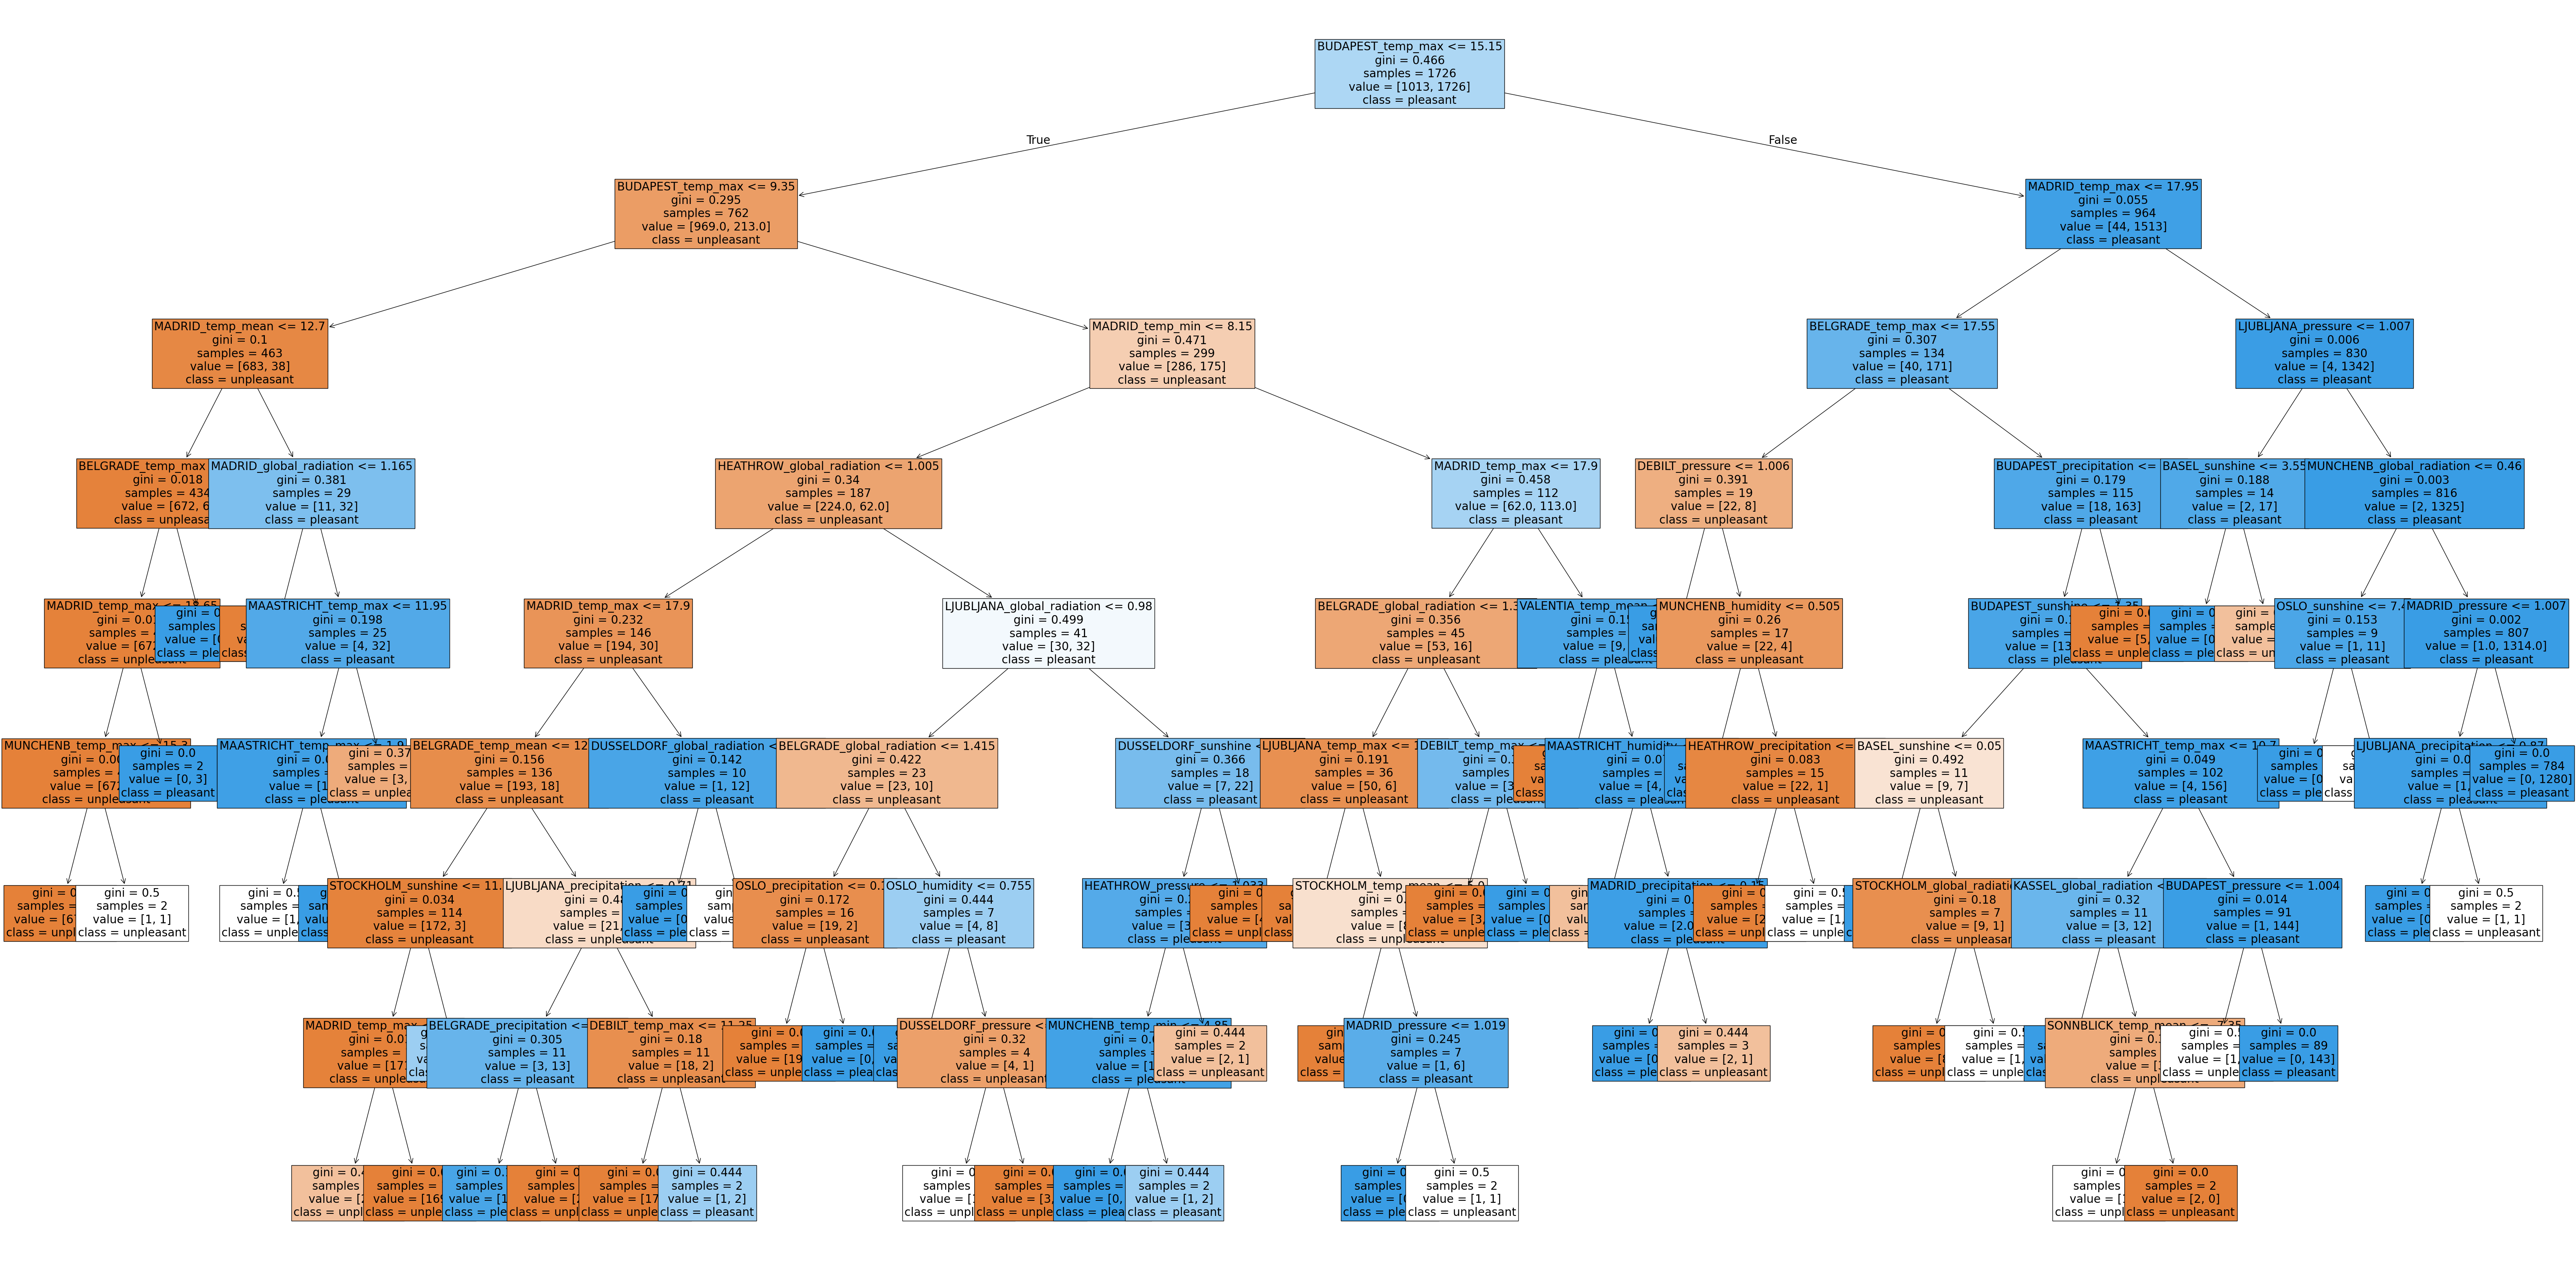

In [16]:
# Random tree for 2000's

fig = plt.figure(figsize=(80,40))
plot_tree(clf00.estimators_[5], fontsize = 20, feature_names=df_00.columns, class_names=['unpleasant', 'pleasant'], filled=True)
plt.show();

## Madrid optimized

In [17]:
# Create a RF classifier

clf2 = RandomForestClassifier()

In [18]:
grid_space = {
    'max_depth': [3, 8, None],  # Focus on a smaller range
    'n_estimators': [50, 100],  # Reduced number of estimators
    'max_features': [15, 50],  # Focus on fewer values
    'min_samples_leaf': [1, 2],  # Smaller range
    'min_samples_split': [2, 3]  # Avoid using 1 (invalid in sklearn)
}

In [19]:
start = time.time()
grid = GridSearchCV(clf2, param_grid=grid_space, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
model_grid = grid.fit(Xm_train, ym_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Search took 0.1346975326538086 minutes


In [20]:
# Print grid search results

print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

Best GRID search hyperparameters are: {'max_depth': 3, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best GRID search score is: 1.0


In [21]:
# Create a RF classifier with the best results from above
clfm = RandomForestClassifier(n_estimators = 50, max_depth=3, max_features=15, min_samples_leaf=1, min_samples_split=2)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clfm.fit(Xm_train, ym_train)

RandomForestClassifier(max_depth=3, max_features=15, n_estimators=50)

In [22]:
# Perform predictions on the test dataset
ym_pred = clfm.predict(Xm_test)
  
# Use metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(ym_test, ym_pred))

Model Accuracy:  1.0


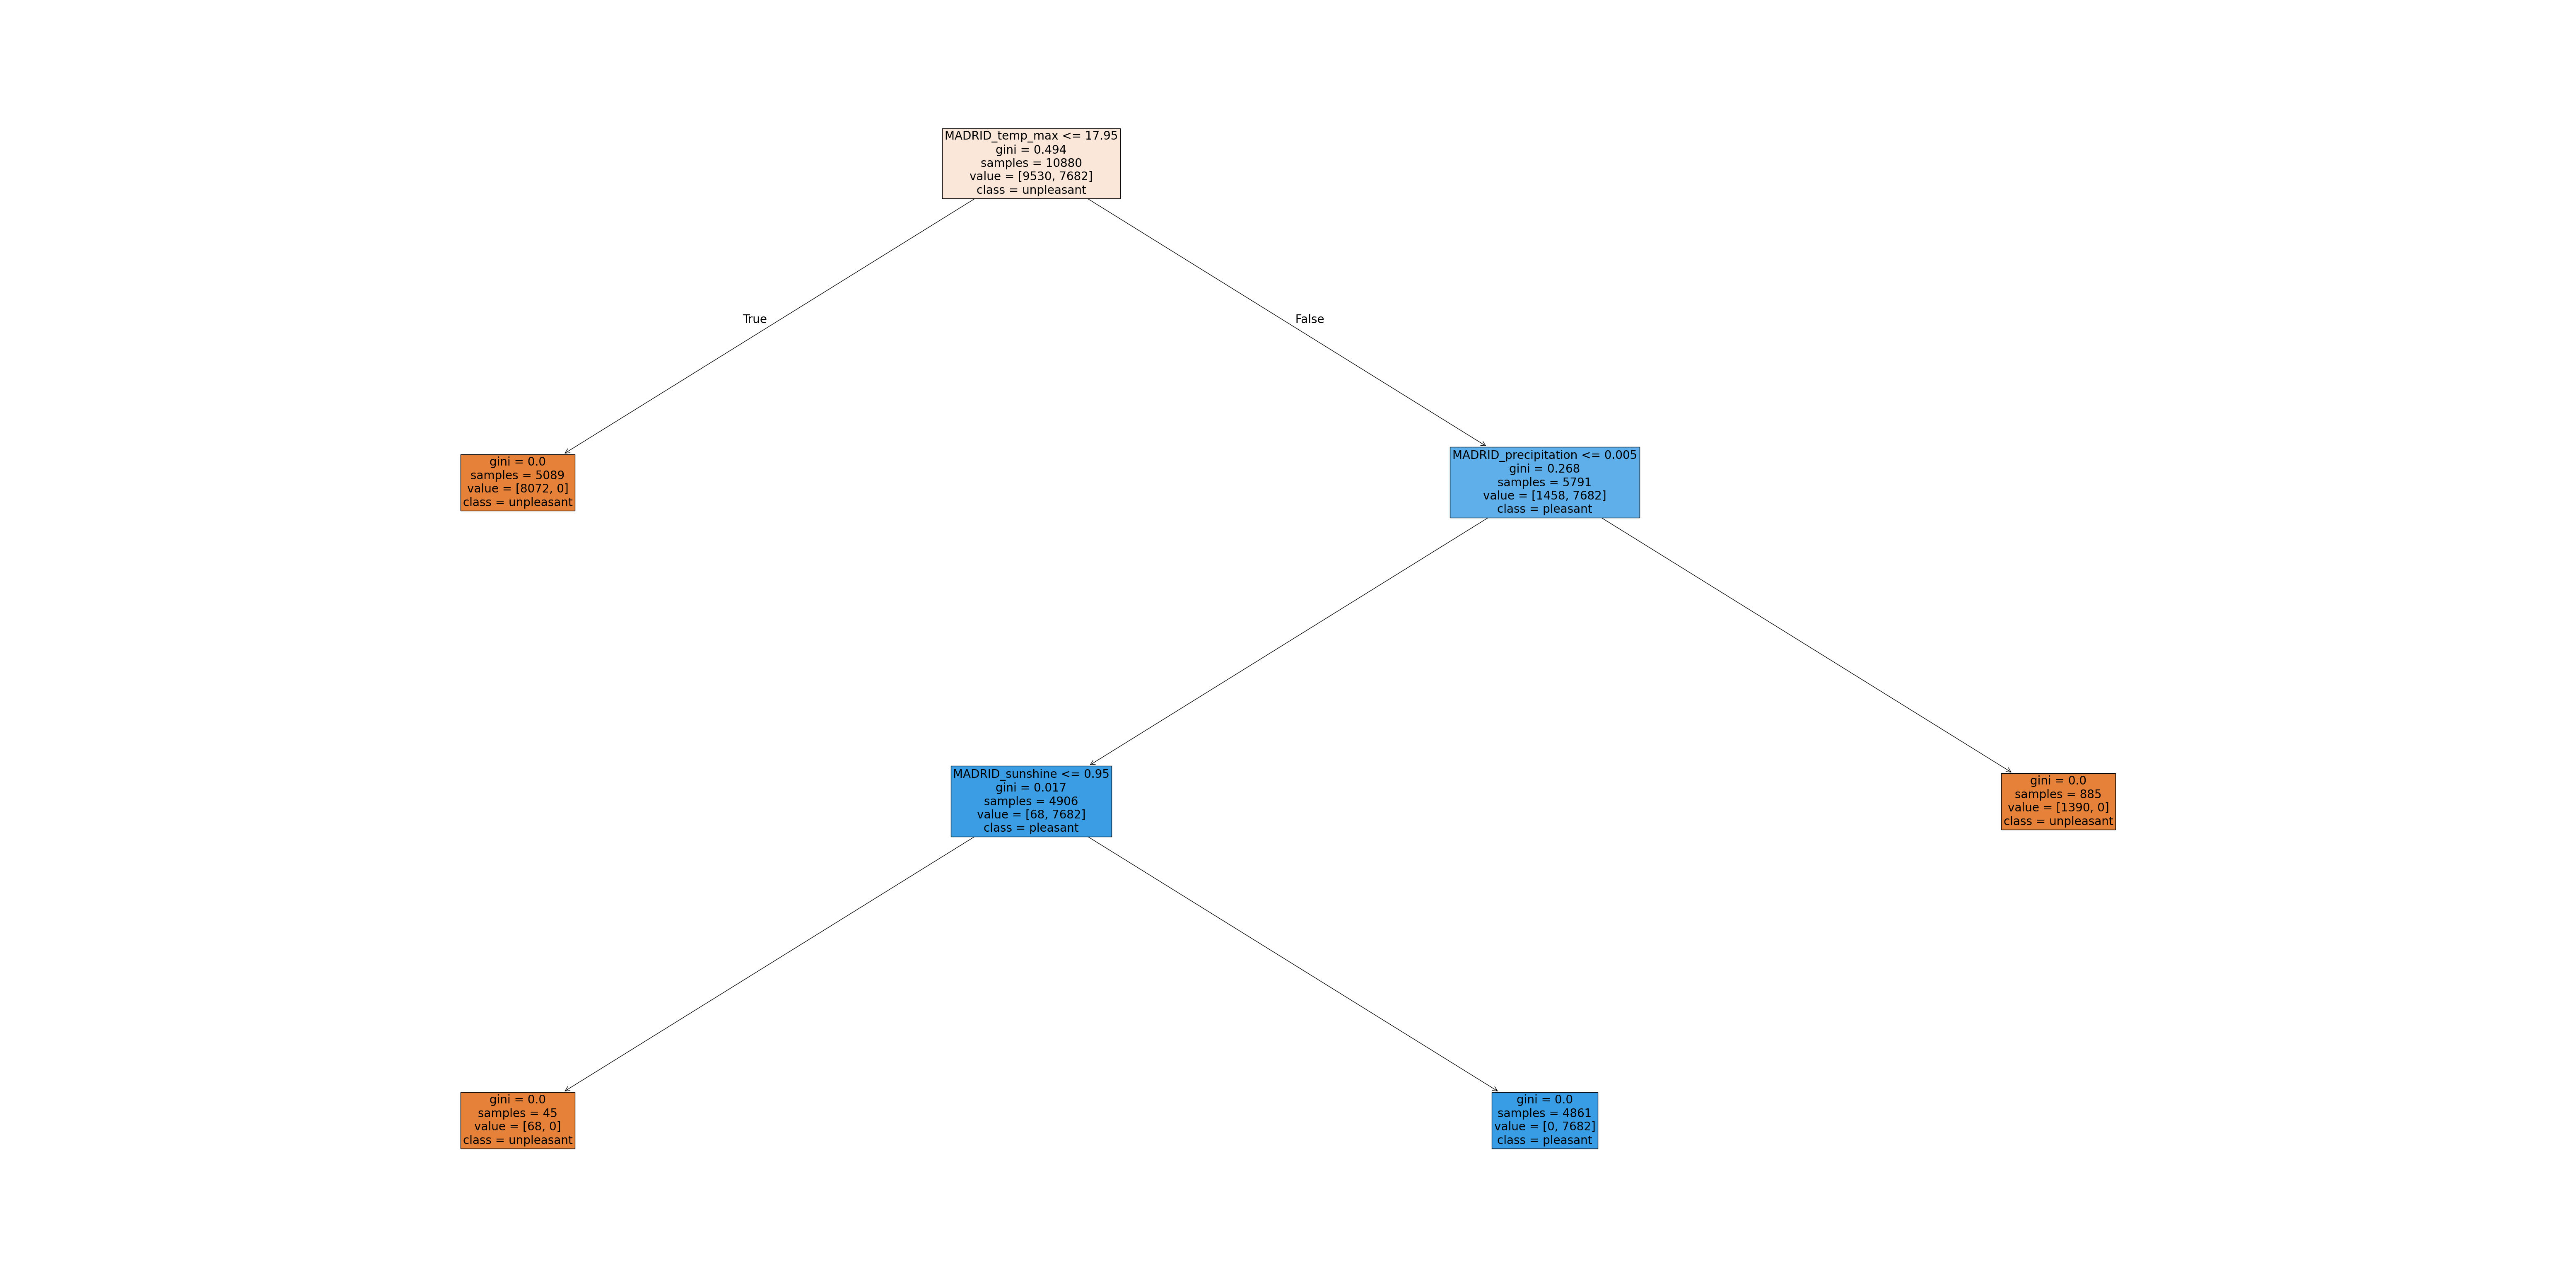

In [23]:
# Random tree for Madrid

fig = plt.figure(figsize=(80,40))
plot_tree(clfm.estimators_[5], fontsize = 20, feature_names=df_mad.columns, class_names=['unpleasant', 'pleasant'], filled=True)
plt.show();

In [24]:
# Retrieve feature importances from the trained model
feature_importances_1 = clf00.feature_importances_
print("Feature Importances:", feature_importances_1)
print(feature_importances_1.shape)

Feature Importances: [2.17674003e-04 4.96261542e-04 2.07465326e-04 3.16944451e-03
 6.45997054e-05 2.35907493e-04 9.56593028e-04 1.97250912e-04
 9.04903275e-03 2.64894251e-03 2.07114561e-03 2.98584553e-04
 3.77378591e-03 1.46118960e-02 3.49241123e-03 4.61393295e-02
 4.76716789e-04 5.22538319e-02 3.20201008e-04 9.03275912e-04
 2.43639286e-04 3.22039536e-03 1.55738799e-03 1.76857493e-03
 7.43976643e-02 5.23740730e-04 1.33766937e-01 1.22110000e-04
 3.69301912e-04 7.13873423e-04 4.70804376e-04 1.69370189e-04
 1.13404593e-04 1.11472274e-03 6.42186339e-04 2.53215147e-03
 8.05335654e-05 1.78063102e-04 4.43530400e-04 3.59680084e-04
 2.69293127e-04 3.86789666e-04 2.56985997e-03 6.30552001e-04
 2.71196016e-03 1.59370151e-04 4.55327830e-04 6.57610999e-04
 1.73706716e-03 1.98702900e-04 4.41442727e-04 7.29482130e-04
 7.01809987e-04 6.73226649e-03 2.46923326e-04 3.74413495e-04
 8.13259744e-04 2.96061003e-04 2.03275053e-04 2.45343415e-04
 3.18841832e-03 4.26444963e-04 5.35163846e-03 7.04036566e-05
 4.

In [25]:
# Reshape the feature importances to (-1, 15, 9)
reshaped_importances_1 = feature_importances_1.reshape(-1, 15, 9)

# Check shape
print("Reshaped Importances Shape:", reshaped_importances_1.shape)

Reshaped Importances Shape: (1, 15, 9)


In [26]:
# Sum the values across the last dimension to get one observation for each weather station
collapsed_importances_1 = np.sum(reshaped_importances_1[0], axis=1)

# Check shape
print("Collapsed Importances Shape:", collapsed_importances_1.shape)
print("Collapsed Importances:", collapsed_importances_1)

Collapsed Importances Shape: (15,)
Collapsed Importances: [0.01459423 0.12576664 0.21670182 0.00624793 0.00763026 0.01181308
 0.01114578 0.13158608 0.00557481 0.43342647 0.01812082 0.0033092
 0.00464523 0.00542027 0.00401739]


In [27]:
# Create list for weather stations
weather_stations = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 
                    'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 
                    'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']

In [28]:
# Create a dataframe to associate weather stations with their importances
collapsed_importances_df_1 = pd.DataFrame({
    'Weather Station': weather_stations,
    'Importance': collapsed_importances_1
})

In [29]:
# Sort by importance for chart readability
collapsed_importances_df_1 = collapsed_importances_df_1.sort_values(by='Importance', ascending=False)
print("Collapsed Feature Importances:")
print(collapsed_importances_df_1)

Collapsed Feature Importances:
   Weather Station  Importance
9           MADRID    0.433426
2         BUDAPEST    0.216702
7        LJUBLJANA    0.131586
1         BELGRADE    0.125767
10        MUNCHENB    0.018121
0            BASEL    0.014594
5         HEATHROW    0.011813
6           KASSEL    0.011146
4       DUSSELDORF    0.007630
3           DEBILT    0.006248
8       MAASTRICHT    0.005575
13       STOCKHOLM    0.005420
12       SONNBLICK    0.004645
14        VALENTIA    0.004017
11            OSLO    0.003309


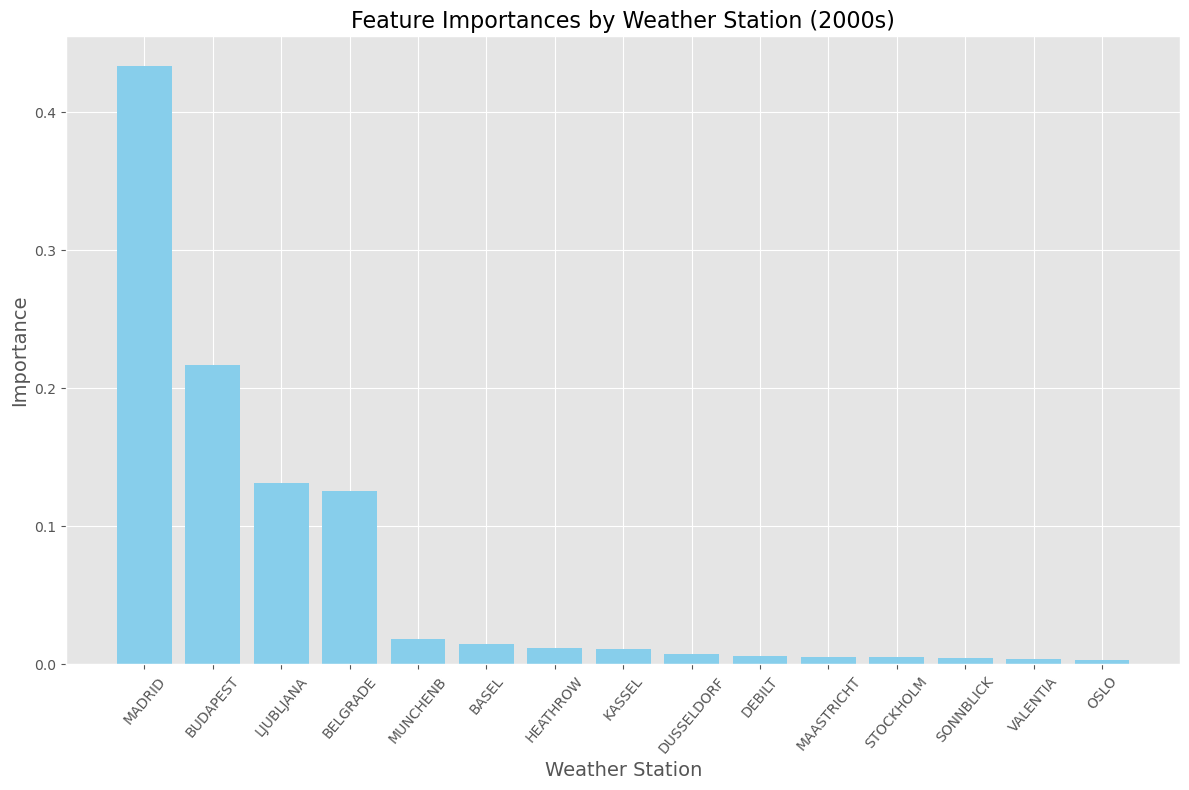

In [30]:
# Plot the importances

plt.style.use('ggplot')
plt_1 = plt.figure(figsize=(12, 8))
plt.bar(collapsed_importances_df_1['Weather Station'], collapsed_importances_df_1['Importance'], color='skyblue')
plt.xticks(rotation=50, ha='center')
plt.xlabel('Weather Station', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Feature Importances by Weather Station (2000s)', fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
feature_importances_m = clfm.feature_importances_
print("Feature Importances:", feature_importances_m)

Feature Importances: [0.         0.         0.         0.         0.27364422 0.01540922
 0.         0.         0.71094655]


In [33]:
# Create list for observation measurements
measurements = [
    'cloud_cover', 'humidity', 'pressure', 'global_radiation', 
    'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max'
]

In [34]:
# Create a dataframe to associate observation measurements with their importances
importances_m = pd.DataFrame({
    'Measurement': measurements,
    'Importance': feature_importances_m
})

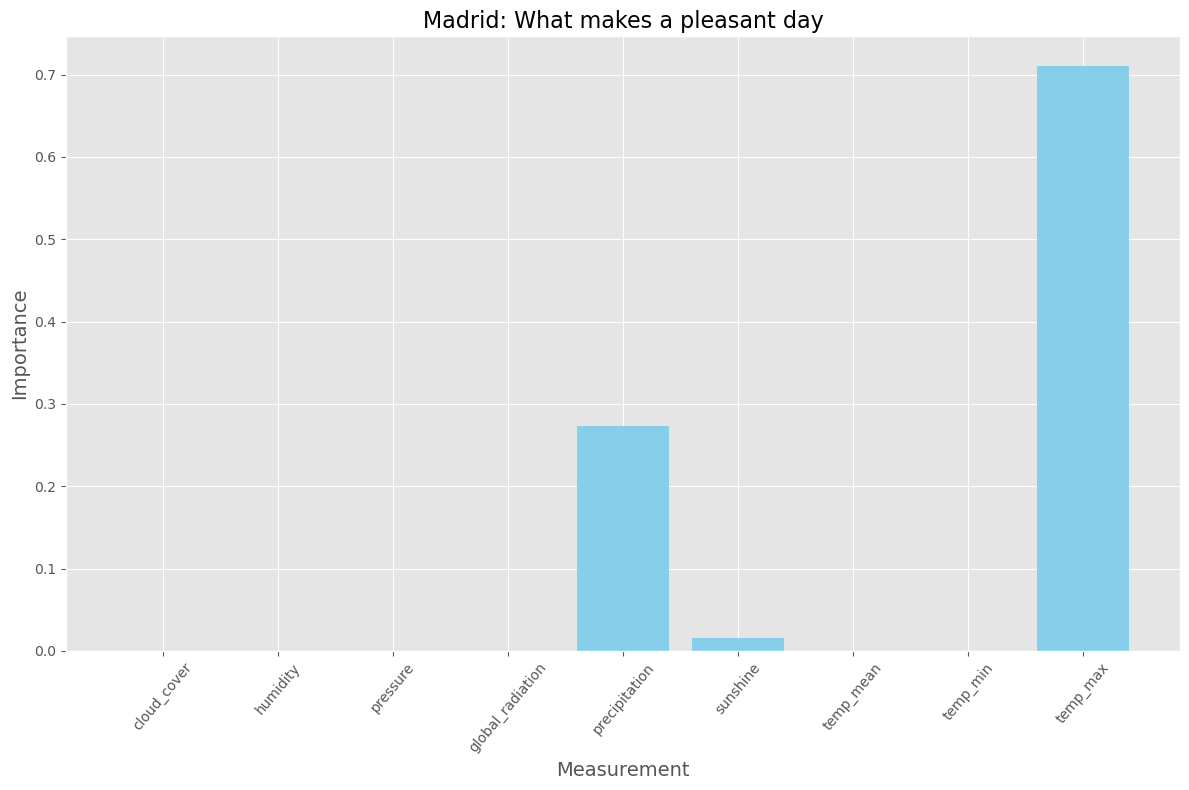

In [35]:
# Plot the importances

plt.style.use('ggplot')
plt_2 = plt.figure(figsize=(12, 8))
plt.bar(importances_m['Measurement'], importances_m['Importance'], color='skyblue')
plt.xticks(rotation=50, ha='center')
plt.xlabel('Measurement', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Madrid: What makes a pleasant day', fontsize=16)
plt.tight_layout()
plt.show()